# VAE-XGBoost

In [1]:
!python --version

Python 3.10.6


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

Mounted at /content/gdrive


In [3]:
!pip install xgboost

In [41]:
#imports
print("Starting imports")
#basics
import time
print("Starting timer.")
startTime = time.time()

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

#XGBoost Specific
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

#VAE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#h5 conversion
import h5py

print("Imports Complete")

Starting imports
Starting timer.
Imports Complete


In [5]:
datetimeCurr = datetime.datetime.now().strftime("%y%M%d_%H%M%S")
print(f"Current Datetime File Association: {datetimeCurr}")

Current Datetime File Association: 231824_171856


## Get Data

In [6]:
#paths
mainPath = '/content/gdrive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Yi_Work'

data_full_ = mainPath + '/Data/data_full.csv' #training and test combined
data_1201_ = mainPath + '/Data/df_1201_validation_data.csv'

h5SavePath = mainPath + "/Data/myh5"

In [7]:
#read data in
print("Reading Data In_")
df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)
print("Data read in completed.")

Reading Data In_
Data read in completed.


## Create functions from Homayra

In [8]:
print("Establishing RMSPE functions.")

Establishing RMSPE functions.


In [9]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [10]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

In [11]:
print("Function established.")

Function established.


## Clean Data/Prepare Data

In [12]:
print("Begin data cleaning.")

Begin data cleaning.


In [13]:
df1201 = df1201.drop(columns = ['Unnamed: 0'])
df_all = df_all.drop(columns = ['Unnamed: 0'])

In [14]:
#compute vmag to match final process for result comparison.
df_all['v_mag'] = np.sqrt(df_all['surf_vx']**2 + df_all['surf_vy']**2)
df1201['v_mag'] = np.sqrt(df1201['surf_vx']**2 + df1201['surf_vy']**2)

In [15]:
#1201 drop location variables
df1201_feats = df1201.drop(columns = ['surf_x', 'surf_y'])

In [16]:
#df_all drop location variables
df_all_feats_target = df_all.drop(columns = ['surf_x', 'surf_y', 'track_bed_x', 'track_bed_y'])

In [17]:
#1201 order to align with df_all
df1201_feats_ordered = df1201_feats[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB','v_mag']]

In [18]:
#set the feature variables to our independent characteristic variables
feature_cols = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB','v_mag']

In [19]:
#split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

In [20]:
#combine all known X and validation 1201 X for standardizing
X_all = np.concatenate((X_given, df1201_feats_ordered))

In [21]:
#make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

In [22]:
print("Data cleaned.\nScaling beginning.")

Data cleaned.
Scaling beginning.


In [23]:
#standardize
#Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

#can alternatively use the MinMaxScaler

In [24]:
print("Scaling Complete.\nSplitting Data Beginning.")

Scaling Complete.
Splitting Data Beginning.


In [25]:
#split of 1201 data from X_all_std
X_non1201 = X_all_std[0:632706,:]
X_1201_data = X_all_std[632706:, :]

In [26]:
#generate a randomseed for training and testing split
generated = 168
print(f"Generated random split for train-test: {generated}")

Generated random split for train-test: 168


In [27]:
#set the train-test split
#60-40 showed the most promising from previous research
train_size_ = .6

In [28]:
#split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(X_non1201, Y_all_std, train_size = train_size_, test_size = 1-train_size_, random_state = generated)

#get validation data
val_split = .2 #can change as needed
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1-val_split, test_size = val_split, random_state = generated)

In [29]:
print(f"Data train-split complete with: {train_size_ * 100}% training, {(1- train_size_) * 100}% testing, {val_split*100}% validation")

Data train-split complete with: 60.0% training, 40.0% testing, 20.0% validation


## Modeling

## VAE

In [30]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#ENCODER
latent_dim = 2

encoder_inputs = keras.Input(shape=(6,))
x = layers.Dense(32, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

#DECODER
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
decoder_outputs = layers.Dense(1)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

#CLASS
class VAE(keras.Model):
    def __init__(self, encoder, decoder, num_columns, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.num_columns = num_columns
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x_train, y_train = data  # Unpack the input data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_train)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(y_train, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed


## Train

In [31]:
%%time
#TRAIN VAE
num_columns = 6
vae = VAE(encoder, decoder, num_columns)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=712)

Epoch 1/10
427/427 [==============================] - 6s 6ms/step - loss: 1.0031 - reconstruction_loss: 0.9645 - kl_loss: 0.0254 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/10
427/427 [==============================] - 3s 6ms/step - loss: 0.8796 - reconstruction_loss: 0.6576 - kl_loss: 0.2043 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/10
427/427 [==============================] - 3s 8ms/step - loss: 0.8359 - reconstruction_loss: 0.6045 - kl_loss: 0.2230 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/10
427/427 [==============================] - 2s 5ms/step - loss: 0.8134 - reconstruction_loss: 0.5815 - kl_loss: 0.2306 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/10
427/427 [==============================] - 2s 5ms/step - loss: 0.8035 - reconstruction_loss: 0.5649 -

In [32]:
# Get the feats from the VAE encoder
_, _, latent_features = vae.encoder.predict(x_train)
# combined_features = np.concatenate((x_train, latent_features), axis=1)

9491/9491 [==============================] - 9s 919us/step


## XGB

In [33]:
#define
xgb_model = XGBRegressor(
  max_depth=7,
  n_estimators=350,
  min_child_weight=0.25,
  subsample=0.8,
  eta=0.25,
  seed=generated)

In [34]:
%%time
#TRAIN XGB with combined xtrain and vae encoder feats
xgb_model.fit(latent_features,
              y_train,
              eval_metric="rmse",
              verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


CPU times: user 1min 40s, sys: 126 ms, total: 1min 40s
Wall time: 56.6 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.25, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=0.25, missing=nan,
             monotone_constraints=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [35]:
%%time
# Evaluate the combined model

# Pass the latent samples through the decoder
_, _, generated_data = vae.encoder.predict(x_test)
# combined_features_val = np.concatenate((x_test, generated_data), axis=1)
y_pred_test = xgb_model.predict(generated_data)

#rescale
test_predict_full_scale = scaler_Y.inverse_transform(y_pred_test.reshape(-1,1))
y_test_given_full_range = scaler_Y.inverse_transform(y_test.reshape(-1,1))

# Evaluate the model performance
print("Print testing stats statements.")

#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_test_given_full_range, test_predict_full_scale)))
print('RMSE Percentage:',rmspe(y_test_given_full_range, test_predict_full_scale))
# print('RMSE Percentage-1:',rmspe_1(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_given_full_range, test_predict_full_scale))
print('R^2 Score:', r2_score(y_test_given_full_range, test_predict_full_scale))

7909/7909 [==============================] - 7s 889us/step
Print testing stats statements.
RMSE: 129.75976429980784
RMSE Percentage: 3888.079988801366
Mean Absolute Error: 100.03457276030343
Mean Absolute Percentage Error: 1.5122093676304211
R^2 Score: 0.4807987751170596
CPU times: user 17.1 s, sys: 613 ms, total: 17.7 s
Wall time: 15.4 s


# 1201

In [36]:
print("Predicting 1201")
start1201Prediction = time.time()

#predict
_, _, latent_features_val = vae.encoder.predict(X_1201_data)
# combined_features_val = np.concatenate((X_1201_data, latent_features_val), axis=1)
y_pred_1201 = xgb_model.predict(latent_features_val)

#rescale
pred1201_normScale = scaler_Y.inverse_transform(y_pred_1201.reshape(-1,1))

end1201Prediction = time.time()
print(f"Predicting 1201 Complete.\nTime taken: {end1201Prediction-start1201Prediction:.03f}ms")

Predicting 1201
45076/45076 [==============================] - 44s 969us/step
Predicting 1201 Complete.
Time taken: 93.662ms


In [37]:
print("Converting 1201 prediction 1201 shape.")

y_Predict_1201_full_flatten=pred1201_normScale.flatten()
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)

print("1201 ready for validation checks.")

Converting 1201 prediction 1201 shape.
1201 ready for validation checks.


In [38]:
d1201Comparison = pd.DataFrame(prediction_on_1201_2D)

#transpose the datasets to face the correct NSEW directions.
data_set1 = np.transpose(d1201Comparison)
data_set1 = np.flipud(data_set1)

In [39]:
modelNameYoureRunning = "VAE&XGB"
interpolatedDataYoureRunning = "Nearest Neighbors"

<ipython-input-42-4aebd26e0187>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels


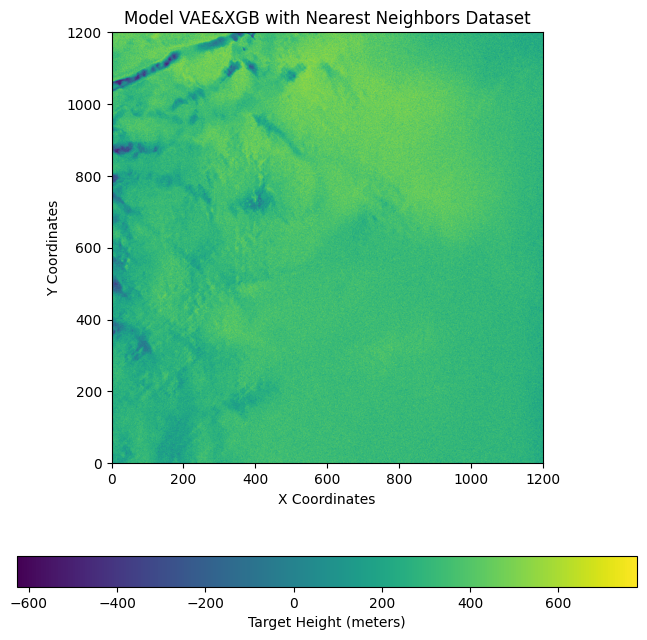

In [42]:
figRunName = f"Model {modelNameYoureRunning} with {interpolatedDataYoureRunning} Dataset"
min_value = -626.96027
max_value = 778.96765

# Create a figure and subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# Assuming data_set1 is defined and contains your data
# Plot the first data set with shared color scale
im1 = axs.imshow(data_set1, vmin=min_value, vmax=max_value)
axs.set_title(f'{figRunName}')
axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels
axs.set_xlabel("X Coordinates")
axs.set_ylabel("Y Coordinates")

# Define the colormap
colors = [
    (0.0, 0.0, 0.0),    # Black
    (0.0, 0.0, 0.3),    # Darker blue
    (0.0, 0.0, 0.5),    # Dark blue
    (0.0, 0.0, 0.7),    # Blue
    (0.0, 0.0, 1.0),    # Blue
    (0.0, 0.4, 0.8),    # Lighter blue
    (0.0, 0.6, 0.2),    # Dark green
    (0.0, 0.7, 0.3),    # Green
    (0.2, 0.8, 0.4),    # Light green
    (1.0, 0.8, 0.0),    # Orange
    (1.0, 0.0, 0.0),    # Red
]
mapColor = LinearSegmentedColormap.from_list('WaterTreesMountains', colors)

# Add colorbar to the plot
fig.colorbar(im1, label="Target Height (meters)", ax=axs, location='bottom')

plt.show()
plt.close()


In [ ]:
endTime = time.time()
print(f"Total Time Taken: {endTime - startTime:.03f}ms")
print("GPR COMPLETE")